## Issues

-figure out best way to handle dimensions for euclidean and cosine distance
   
   - test how they work with different dimensions: diff combinations of nx1,
    nxp, 1xn, nxm, etc.
   
   - cosine distance may need troubleshooting
   
-test how X_new works with diff dimensions

## K Nearest Neighbors

In [171]:
a = np.array(['red', 'green', 'red,', 'yellow', 'red'])
np.where(a == 'red', 1, 0)

array([1, 0, 0, 0, 1])

In [6]:
import numpy as np

In [172]:
def classify_response(val):
    """Parse response column from csv."""
    return np.where(val == 'Abnormal', 1, 0)

In [168]:
def scale_mean(df, fitted_stats=None):
    """Pass in df of features. Scale each column by subtracting 
    its mean and dividing by its standard deviation. Return an array 
    with these statistics for each column.
    """
    if fitted_stats is not None:
        means, stds = fitted_stats['means'], fitted_stats['stds']
    else:
        means = np.mean(df, axis=0)
        stds = np.std(df, axis=0)
        fitted_stats = dict(means=means, stds=stds)
    df = (df - means) / stds
    return df, fitted_stats

In [169]:
def scale_minmax(df, fitted_stats=None):
    """Pass in df of features. Scale each column so its values 
    lie between 0 and 1. Return an array with min and max for each
    column.
    """
    if fitted_stats is not None:
        mins, maxes = fitted_stats['mins'], fitted_stats['maxes']
    else:
        mins = np.min(df, axis=0)
        maxes = np.max(df, axis=0)
        fitted_stats = dict(mins=mins, maxes=maxes)
    df = (df - mins) / (maxes - mins)
    return df, fitted_stats

In [10]:
def euclidean(vec1, vec2):
    """Find euclidean distance between two ndarrays (rank 2).
    """
    assert len(vec1.shape) == len(vec2.shape) == 2,\
        'Vectors must be 2d arrays'
    return np.sqrt(np.sum((vec1 - vec2) ** 2, axis=1))

In [11]:
def cosine_distance(vec1, vec2):
    """Find cosine distance between two vectors. Both vectors should be 
    ndarrays of shape (n, 1).
    """
    assert len(vec1.shape) == len(vec2.shape) == 2,\
        'Vectors must be 2d arrays'
    zeros = np.zeros(shape=vec1.shape)
    print(vec1.T @ vec2)
    print(euclidean(vec1, zeros))
#     sim = (vec1.T @ vec2) / (euclidean(vec1, zeros) * euclidean(vec2, zeros))
#     return 1 - sim

In [12]:
def mode(classes):
    """Find the most common class from a list or array of numbers."""
    class_counts = [(c, list(classes).count(c)) for c in set(classes)]
    return sorted(class_counts, key=lambda x: x[1], reverse=True)[0][0]

In [199]:
class KNN_classifier():
    
    def __init__(self, X_train, y_train, k=5, scale_method='mean', 
                 distance='euclidean'):
        self.X = X_train
        self.y = y_train
        self.k = k
        self.scale_method = scale_method
        self.distance = distance
        if self.scale_method:
            self.X_scaled, self.stats = self._scale_features(self.X)

    def _scale_features(self, df, stats=None):
        """Scale features using specified method."""
        if self.scale_method == 'mean':
            return scale_mean(df, fitted_stats=stats)
        elif self.scale_method == 'minmax':
            return scale_minmax(df, fitted_stats=stats)
            
    def _find_neighbors(self):
        """Finds indices of the k observations with the smallest
        distances.
        """
        self.nearest_neighbors = np.argsort(self.distances)[:self.k]

    def predict(self, X_new, k=5):
        """Pass in 2d array of x values. Return indices and distances of
        k nearest neighbors from the train set."""
        if self.scale_method:
            X_new_scaled, _ = self._scale_features(X_new, stats=self.stats)
        if self.distance == 'euclidean':
            self.distances = euclidean(X_new_scaled, self.X_scaled)
        elif self.distance == 'cosine':
            self.distances = cosine_distance(X_new_scaled, self.X_scaled)
        self._find_neighbors()
        self.neighbor_distances = self.distances[self.nearest_neighbors]
        
        # Select most common class among nearest neighbors.
        self.neighbor_classes = self.y[self.nearest_neighbors]
        self.class_certainty = np.mean(self.neighbor_classes)
        self.predicted_class = mode(self.neighbor_classes)
        
        return dict(predicted_class=self.predicted_class,
                    class_certainty=self.class_certainty,
                    nearest_neighbors=self.nearest_neighbors,
                    neighbor_classes=self.neighbor_classes,
                    neighbor_distances=self.neighbor_distances)
    
    def __str__(self):
        """Display object details when printed."""
        return (f'KNN_classifier(k={self.k}, distance={self.distance},'
                f' scale_method={self.scale_method})')
    
    def __repr__(self):
        """Display object details when called in interactive mode."""
        return self.__str__()

In [332]:
X = np.loadtxt('bio.csv', skiprows=1, delimiter=',', usecols=range(6))
y = np.loadtxt('bio.csv', skiprows=1, delimiter=',', usecols=6, dtype=np.str)
y = classify_response(y)

In [333]:
mod = KNN_classifier(X_train=X, y_train=y, scale_method='mean',
                     distance='euclidean')
mod

KNN_classifier(k=5, distance=euclidean, scale_method=mean)

In [334]:
np.random.seed(1)
X_new = np.mean(X, axis=0) * np.random.rand(1, 1) * 3
pred1 = mod.predict(X_new)
pred1

{'class_certainty': 0.6,
 'nearest_neighbors': array([ 83, 226, 275, 200,  60]),
 'neighbor_classes': array([1, 0, 0, 1, 1]),
 'neighbor_distances': array([1.24555067, 1.2904598 , 1.49994867, 1.65254366, 1.66789103]),
 'predicted_class': 1}

In [335]:
mod2 = KNN_classifier(X, y, 5, 'minmax', 'euclidean')
mod2

KNN_classifier(k=5, distance=euclidean, scale_method=minmax)

In [336]:
pred2 = mod2.predict(X_new)
pred2

{'class_certainty': 0.6,
 'nearest_neighbors': array([ 83, 226, 275, 200,  60]),
 'neighbor_classes': array([1, 0, 0, 1, 1]),
 'neighbor_distances': array([0.16449334, 0.18427276, 0.21774205, 0.23828272, 0.25277844]),
 'predicted_class': 1}

In [294]:
np.mean(X, axis=0).shape

(6,)

In [340]:
X_multi = np.mean(X, axis=0) * np.random.rand(5, 6) * 3
print(X_multi)
mod.predict(X_multi)

[[ 62.71580211  20.88126349  83.94376165  54.01803093 242.40459697
   16.12925501]
 [159.36949734   1.44136701 104.45400322  53.77451982 197.64321158
   11.07513728]
 [ 35.95343109  42.14195823 150.84817118  40.3883075  244.91740898
   69.13841324]
 [162.36212649   4.47574638   6.0844536   21.8846014  310.65341763
    7.75858991]
 [ 76.42680551  50.41225648  83.06330664  89.1563178  111.61742964
   54.15811538]]


ValueError: operands could not be broadcast together with shapes (5,6) (310,6) 

In [352]:
print(X.shape)
X

(310, 6)


array([[ 63.0278175 ,  22.55258597,  39.60911701,  40.47523153,
         98.67291675,  -0.25439999],
       [ 39.05695098,  10.06099147,  25.01537822,  28.99595951,
        114.4054254 ,   4.56425864],
       [ 68.83202098,  22.21848205,  50.09219357,  46.61353893,
        105.9851355 ,  -3.53031731],
       ...,
       [ 61.44659663,  22.6949683 ,  46.17034732,  38.75162833,
        125.6707246 ,  -2.70787952],
       [ 45.25279209,   8.69315736,  41.5831264 ,  36.55963472,
        118.5458418 ,   0.21475017],
       [ 33.84164075,   5.07399141,  36.64123294,  28.76764934,
        123.9452436 ,  -0.19924909]])

In [394]:
tmp = np.arange(24).reshape(4, 6)
print(tmp)
# 1st index of output is row of X. 2nd index is row in tmp. Third index is item in row.
print((np.expand_dims(X[:3,:], axis=1) - tmp))

[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]]
[[[ 63.0278175   21.55258597  37.60911701  37.47523153  94.67291675
    -5.25439999]
  [ 57.0278175   15.55258597  31.60911701  31.47523153  88.67291675
   -11.25439999]
  [ 51.0278175    9.55258597  25.60911701  25.47523153  82.67291675
   -17.25439999]
  [ 45.0278175    3.55258597  19.60911701  19.47523153  76.67291675
   -23.25439999]]

 [[ 39.05695098   9.06099147  23.01537822  25.99595951 110.4054254
    -0.43574136]
  [ 33.05695098   3.06099147  17.01537822  19.99595951 104.4054254
    -6.43574136]
  [ 27.05695098  -2.93900853  11.01537822  13.99595951  98.4054254
   -12.43574136]
  [ 21.05695098  -8.93900853   5.01537822   7.99595951  92.4054254
   -18.43574136]]

 [[ 68.83202098  21.21848205  48.09219357  43.61353893 101.9851355
    -8.53031731]
  [ 62.83202098  15.21848205  42.09219357  37.61353893  95.9851355
   -14.53031731]
  [ 56.83202098   9.21848205  36.09219357  31.61353893  89.9851355


In [417]:
# Reshape new data (tmp) into m 1xn rows. Then sum over last axis to get row-wise sums.
# Output has a row for each new ex, where each item in row is distance to i'th
# row in X.
np.sqrt(((X[:3,:] - np.expand_dims(tmp, axis=1)) ** 2).sum(axis=-1))

array([[127.46147766, 122.48506995, 140.98512379],
       [116.07510095, 112.84238915, 129.57728383],
       [105.51033047, 104.38494728, 118.8938175 ],
       [ 96.0386933 ,  97.42191564, 109.14763944]])

In [415]:
for row in tmp:
    print((X[:3] - row).sum(axis=1))

[249.08326877 207.09896422 275.21105372]
[213.08326877 171.09896422 239.21105372]
[177.08326877 135.09896423 203.21105372]
[141.08326877  99.09896423 167.21105372]


## Scikit-Learn Implementation

In [223]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [318]:
df = pd.read_csv('bio.csv')
X = df.iloc[:, :-1]
y = (df['class'] == 'Abnormal') * 1
df.head()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


In [320]:
df.groupby('class').mean()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
class,,,,,,
Abnormal,64.692562,19.791111,55.925370,44.90145,115.077713,37.777705
Normal,51.685244,12.821414,43.542605,38.86383,123.890834,2.186572


In [321]:
df.mean()

pelvic_incidence             60.496653
pelvic_tilt numeric          17.542822
lumbar_lordosis_angle        51.930930
sacral_slope                 42.953831
pelvic_radius               117.920655
degree_spondylolisthesis     26.296694
dtype: float64

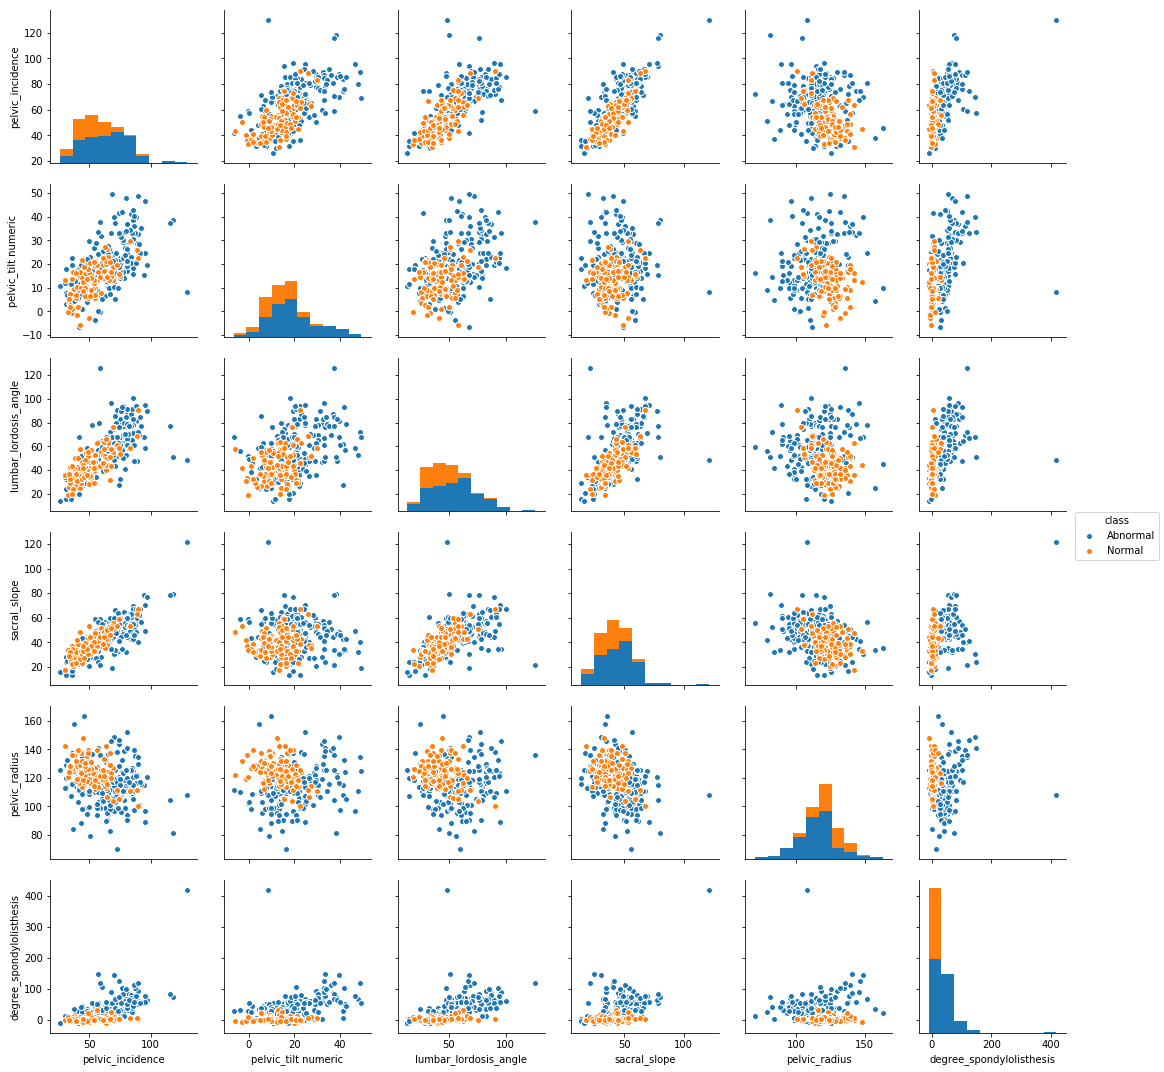

In [25]:
sns.pairplot(data=df, hue='class')
plt.show()

In [233]:
scaler = StandardScaler()
sk_knn = KNeighborsClassifier(n_neighbors=5)

In [282]:
X_scaled = scaler.fit_transform(X)
X_new_scaled = scaler.transform(X_new)
sk_knn.fit(X_scaled, y)
pred = sk_knn.predict(X_new_scaled)[0]
distances, kneighbors = sk_knn.kneighbors(X_new_scaled)

In [283]:
print(f'Predicted class: {pred}')
print(f'Nearest neighbors: {kneighbors.flatten()}')
print(f'Neighbor distances: {distances.flatten()}')

Predicted class: 1
Nearest neighbors: [ 83 226 275 200  60]
Neighbor distances: [1.24555067 1.2904598  1.49994867 1.65254366 1.66789103]
